Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.
6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [71]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import seaborn as sns
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
from operator import attrgetter
from datetime import timedelta

In [72]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/olist_customers_dataset.csv')
# датасет с инофрмацией о пользователях 
df1 = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/olist_orders_dataset.csv', 
                  parse_dates=['order_purchase_timestamp', 
                               'order_approved_at', 
                               'order_delivered_carrier_date', 
                               'order_delivered_customer_date', 
                               'order_estimated_delivery_date'])
# датасет с информацие о статусе заказов
df2= pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-d-ivashkin-23/olist_order_items_dataset.csv', 
                 parse_dates=['shipping_limit_date'])
# датасет с информацией о заказах

1. Сколько у нас пользователей, которые совершили покупку только один раз?

In [73]:
orders = df.merge(df1)
#объединяем датасеты для подсчёта количества покупок уникальных пользователей

In [74]:
orders.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [75]:
orders.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
customer_city                            object
customer_state                           object
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

"Покупкой" будем считать заказы со статусами 'delivered', 'approved', 'processing' (все статусы до этого момента предполагают,
что пользователь не успел оплатить покупку, эта возможность у него появляется только после присвоения заказу статуса 'invoiced') или с существующей датой  в "order_delivered_customer_date" (на случай, если произошла техническая ошибка и статус заказа не поменялся)

In [76]:
sells = orders \
    .query('order_status == ["processing", "shipped", "delivered"] or order_delivered_customer_date!=""')

In [77]:
only_one_unique_purchase = sells.groupby('customer_unique_id', as_index=False) \
    .agg({'customer_id':'count'}) \
    .rename(columns={'customer_id':'purch_num'}) \
    .query('purch_num == 1')
only_one_unique_purchase.purch_num.sum()

91820

Ответ - 91820 пользователей совершили покупку всего 1 раз

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

In [78]:
not_sold = orders.query('order_status != "delivered"')
not_sold['month'] = not_sold.order_estimated_delivery_date.dt.strftime('%Y-%m')
not_sold['order_estimated_delivery_date'] = not_sold.order_estimated_delivery_date.dt.to_period('M')
not_sold = not_sold \
    .groupby(['month',
              'order_estimated_delivery_date',
              'order_status'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'num_cancelled'}) \
    .groupby(['month','order_status'], as_index=False) \
    .agg({'num_cancelled':'mean'})
not_sold.head()

,month,order_status,num_cancelled
0,2016-09,canceled,1
1,2016-10,canceled,3
2,2016-10,shipped,1
3,2016-11,canceled,14
4,2016-11,invoiced,9


In [79]:
#График, демонстрирующий сколько заказов в месяц в среднем не доставляется по разным причинам
fig = px.line(not_sold, x="month", y="num_cancelled", color='order_status' , labels={
                     "num_cancelled":'Кол-во отменённых заказов',
                     "month": 'Месяц',
                     'order_status':'Детализация по причинам'
                 },
                title="Среднее кол-во отменённых заказов в месяц")
newnames = {'canceled':'Отменён', 
            'created': 'Cоздан', 
            'approved':'Подтверждён', 
            'invoiced':'Выставлен счёт', 
            'processing':'В процессе сборки заказа', 
            'shipped':'Отгружен со склада',
            'unavailable':'Недоступен'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     )
                  )
fig.show()

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

In [80]:
goods = df1.merge(df2)
#объединяем датасеты для задачи
goods.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,aa4383b373c6aca5d8797843e5594415,4869f7a5dfa277a7dca6462dcf3b52b2,2018-08-13 08:55:23,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,d0b61bfb1de832b15ba9d266ca96e5b0,66922902710d126a0e7d26b0e3805106,2017-11-23 19:45:59,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,65266b2da20d04dbe00c5c2d3bb7859e,2c9e548be18521d1c43cde1c582c6de8,2018-02-19 20:31:37,19.90,8.72


Получаем список, в какой день недели какой товар лучше продаётся. 
Так как на маленьком количестве покупок (<5) случается одинаковое количество покупок, то пренебрегаем этим фактом (т.к. число достаточно незначительное) и берём первое значение дня недели.

In [81]:
goods_by_day = goods.query('order_status == ["processing", "shipped", "delivered"] or order_delivered_customer_date!=""')
goods_by_day['dayofweek'] = pd.DatetimeIndex(goods_by_day['order_purchase_timestamp']).day_name()
goods_by_day = goods_by_day \
    .groupby(['dayofweek',
              'order_purchase_timestamp',
              'product_id'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':
                     'num_sold'}) \
    .groupby(['product_id','dayofweek'], as_index=False) \
    .agg({'num_sold':
          'sum'}) \
    .pivot(index='product_id', 
           columns='dayofweek', 
           values='num_sold') \
    .fillna(0)
goods_by_day['max_dayofweek']=goods_by_day.idxmax(axis=1)
print(goods_by_day.max_dayofweek)

product_id
00066f42aeeb9f3007548bb9d3f33c38       Sunday
00088930e925c41fd95ebfe695fd2655      Tuesday
0009406fd7479715e4bef61dd91f2462     Thursday
000b8f95fcb9e0096488278317764d19       Friday
000d9be29b5207b54e86aa1b1ac54872      Tuesday
                                      ...    
fff6177642830a9a94a0f2cba5e476d1     Saturday
fff81cc3158d2725c0655ab9ba0f712c       Monday
fff9553ac224cec9d15d49f5a263411f       Friday
fffdb2d0ec8d6a61f0a0a0db3f25b441      Tuesday
fffe9eeff12fcbd74a2f2b007dde0c58    Wednesday
Name: max_dayofweek, Length: 32614, dtype: object


4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

In [82]:
sells.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12 20:48:24,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05-19 16:07:45,2018-05-20 16:19:10,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03-13 16:06:38,2018-03-13 17:29:19,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07-29 09:51:30,2018-07-29 10:10:09,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15


In [83]:
purchases = sells
purchases['num_of_weeks'] = (purchases.order_estimated_delivery_date.dt.days_in_month) / 7
purchases['month'] = pd.DatetimeIndex(purchases['order_purchase_timestamp']).month
purchases_by_month = purchases \
    .groupby(['customer_unique_id',
              'month', 
              'num_of_weeks'], as_index=False) \
    .agg({'customer_id':
          'count'}) \
    .rename(columns={'customer_id':
                     'num_purchases'})
purchases_by_month['weekly_mean'] = (purchases_by_month.num_purchases 
                                     / purchases_by_month.num_of_weeks)
purchases_by_week = purchases_by_month[['customer_unique_id', 'weekly_mean']]
purchases_by_week

,customer_unique_id,weekly_mean
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.233333
3,0000f6ccb0745a6a4b88665a16c9f078,0.233333
4,0004aac84e0df4da2b147fca70cf8255,0.225806
...,...,...
96746,fffcf5a5ff07b0908bd4e2dbc735a684,0.225806
96747,fffea47cd6d3cc0a88bd621562a9d061,0.225806
96748,ffff371b4d645b6ecea244b27531430a,0.225806
96749,ffff5962728ec6157033ef9805bacc48,0.225806


5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

In [84]:
cohort_df = sells.dropna(axis='index', how='any', subset=['order_approved_at'])

In [85]:
cohort_df["cohort"] = cohort_df.groupby('customer_unique_id')['order_approved_at'].transform('min')

In [86]:
cohort_df.order_purchase_timestamp = cohort_df.order_purchase_timestamp.dt.strftime('%Y-%m')
cohort_df.order_approved_at = cohort_df.order_approved_at.dt.strftime('%Y-%m')
cohort_df.cohort = cohort_df.cohort.dt.strftime('%Y-%m')

In [87]:
cohort_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,num_of_weeks,month,cohort
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05,2017-05,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05,4.285714,5,2017-05
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP,29150127e6685892b6eab3eec79f59c7,delivered,2018-01,2018-01,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06,4.000000,1,2018-01
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2018-05,2018-05,2018-06-11 14:31:00,2018-06-14 17:58:51,2018-06-13,4.285714,5,2018-05
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP,951670f92359f4fe4a63112aa7306eba,delivered,2018-03,2018-03,2018-03-27 23:22:42,2018-03-28 16:04:25,2018-04-10,4.285714,3,2018-03
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2018-07,2018-07,2018-07-30 15:16:00,2018-08-09 20:55:48,2018-08-15,4.428571,7,2018-07


In [88]:
cohort_df_1 = cohort_df \
    .query("'2017-01' <= cohort <= '2017-12'") \
    .groupby(["cohort", "order_approved_at"], as_index=False) \
    .agg({"customer_unique_id": "nunique"})
cohort_df_1.head()

,cohort,order_approved_at,customer_unique_id
0,2017-01,2017-01,705
1,2017-01,2017-02,4
2,2017-01,2017-03,2
3,2017-01,2017-04,1
4,2017-01,2017-05,3


In [89]:
cohort_df_1["cohort"] = pd.to_datetime(cohort_df_1["cohort"]).dt.to_period("m")
cohort_df_1["order_approved_at"] = pd.to_datetime(cohort_df_1["order_approved_at"]).dt.to_period("m")

In [90]:
cohort_df_1['period'] = (cohort_df_1.order_approved_at 
                         - cohort_df_1.cohort) \
                            .apply(attrgetter("n"))

In [91]:
cohort_df_1_p = cohort_df_1.pivot(index='cohort', 
                                  columns = 'period', 
                                  values = 'customer_unique_id')

In [92]:
base = cohort_df_1_p[0]
#вводим единицу для расчёта retention

In [93]:
retention = cohort_df_1_p.divide(base, axis=0).round(4)

In [94]:
retention_style = (retention
            .style
            .set_caption('User retention by cohort')
            .background_gradient(cmap='viridis')
            .highlight_null('white') 
            .format("{:.2%}", na_rep="")) 
retention_style

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,100.00%,0.57%,0.28%,0.14%,0.43%,0.14%,0.43%,0.14%,0.14%,,0.28%,0.28%,0.71%,0.43%,0.14%,0.14%,0.28%,0.43%,0.14%
2017-02,100.00%,0.24%,0.24%,0.18%,0.42%,0.12%,0.24%,0.18%,0.06%,0.18%,0.12%,0.30%,0.12%,0.18%,0.12%,0.06%,0.06%,0.24%,
2017-03,100.00%,0.50%,0.35%,0.35%,0.35%,0.16%,0.16%,0.31%,0.31%,0.12%,0.35%,0.12%,0.23%,0.12%,0.16%,0.23%,0.08%,0.16%,
2017-04,100.00%,0.61%,0.22%,0.17%,0.26%,0.26%,0.35%,0.26%,0.35%,0.17%,0.22%,0.09%,0.04%,0.04%,0.09%,0.09%,0.13%,,
2017-05,100.00%,0.54%,0.48%,0.40%,0.31%,0.34%,0.43%,0.14%,0.26%,0.26%,0.28%,0.34%,0.20%,0.06%,0.20%,0.23%,,,
2017-06,100.00%,0.45%,0.35%,0.39%,0.26%,0.32%,0.35%,0.23%,0.13%,0.23%,0.32%,0.35%,0.16%,0.13%,0.19%,,,,
2017-07,100.00%,0.53%,0.32%,0.19%,0.34%,0.19%,0.32%,0.11%,0.19%,0.24%,0.21%,0.29%,0.13%,0.27%,,,,,
2017-08,100.00%,0.68%,0.36%,0.27%,0.39%,0.53%,0.27%,0.27%,0.12%,0.17%,0.24%,0.17%,0.15%,,,,,,
2017-09,100.00%,0.66%,0.49%,0.34%,0.42%,0.27%,0.22%,0.22%,0.32%,0.17%,0.27%,0.07%,,,,,,,


In [95]:
retention[retention[3] == retention[3].max()].index

PeriodIndex(['2017-05'], dtype='period[M]', name='cohort', freq='M')

Нашли когорту с максимальным значением retention на третий месяц: "2017-05"!

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю.

In [96]:
rfm_df = goods \
    .merge(orders) \
    .query('order_status == ["processing", "shipped", "delivered"] or order_delivered_customer_date!=""')
#создаём датафрейм для когорт

Предположим, что отчёт был выгружен вчера(т.к. даты достаточно давние, то считать на сегодняшний момент не очень осмысленно), поэтому находим "вчерашнюю" дату:

In [97]:
last_day = rfm_df.order_approved_at.max()

Таким образом, можно найти дату "сегодняшнюю":

In [98]:
today = last_day + timedelta(days=1)

Создаём таблицу RFM

R - время от последней покупки пользователя до текущей даты 
F - суммарное количество покупок у пользователя за всё время 
M - стоимость покупок за всё время

In [99]:
rfm_df = rfm_df \
    .groupby('customer_unique_id', as_index=False) \
    .agg({'order_approved_at':
          lambda x: (today - x.max()).days, 
          #находим разницу между "вчера" и "сегодня"
          'product_id': 
          lambda x: len(x), 
          #находим суммарное количество покупок у пользователя за всё время
          'price': 
          lambda x: x.sum()}) 
          #находим стоимость покупок за всё время

In [100]:
rfm_df = rfm_df \
    .rename(columns={'order_approved_at': 'r', 
                     'product_id': 'f', 
                     'price': 'm'})
#переименовываем колонки

In [101]:
rfm_df.r.describe()

count    94678.000000
mean       243.306227
std        152.826553
min          1.000000
25%        119.000000
50%        224.000000
75%        352.000000
max        719.000000
Name: r, dtype: float64

Сегментируем r-score: 1 - если заказывал меньше чем 30 дней назад, 2 - в интервале от 30-90 дней, 3 - позже, чем 90 дней назад

In [102]:
rfm_df['r_score'] = rfm_df.m \
    .apply(lambda x: 
               3 if x > 92 
           else 2 if 92 > x 
               and x > 30 
           else 1)
rfm_df.head()

,customer_unique_id,r,f,m,r_score
0,0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,129.90,3
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,18.90,1
2,0000f46a3911fa3c0805444483337064,542.0,1,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,326.0,1,25.99,1
4,0004aac84e0df4da2b147fca70cf8255,293.0,1,180.00,3


In [103]:
rfm_df.f.describe()

count    94691.000000
mean         1.180112
std          0.620173
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         24.000000
Name: f, dtype: float64

Cегментируем f-score: 1 - меньше 2 заказов, 2 - 2 заказа, 3 - более 2 заказов:

In [104]:
rfm_df['f_score'] = rfm_df.f \
    .apply(lambda x: 
               3 if x > 2 
           else x)
rfm_df.head()

,customer_unique_id,r,f,m,r_score,f_score
0,0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,129.90,3,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,18.90,1,1
2,0000f46a3911fa3c0805444483337064,542.0,1,69.00,2,1
3,0000f6ccb0745a6a4b88665a16c9f078,326.0,1,25.99,1,1
4,0004aac84e0df4da2b147fca70cf8255,293.0,1,180.00,3,1


In [105]:
rfm_df.m.describe()

count    94691.000000
mean       141.864707
std        215.707794
min          0.850000
25%         47.800000
50%         89.800000
75%        154.910000
max      13440.000000
Name: m, dtype: float64

Cегментируем m-score: 1 - сумма меньше 89.8, 2 - сумма в границах 89.8 - 154.91, 3 - сумма больше 154.91

In [106]:
rfm_df['m_score'] = rfm_df.m \
    .apply(lambda x: 
               3 if x > 154.91 
           else 2 if 154.91 > x 
               and x > 89.8 
           else 1)
rfm_df.dtypes

customer_unique_id     object
r                     float64
f                       int64
m                     float64
r_score                 int64
f_score                 int64
m_score                 int64
dtype: object

И, наконец, склеиваем в единый RFM-score:

In [107]:
rfm_df['rfm_seg'] = (
                     rfm_df.r_score.map(str) 
                     + rfm_df.f_score.map(str) 
                     + rfm_df.m_score.map(str)
                    )
rfm_df.head()

,customer_unique_id,r,f,m,r_score,f_score,m_score,rfm_seg
0,0000366f3b9a7992bf8c76cfdf3221e2,117.0,1,129.90,3,1,2,312
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119.0,1,18.90,1,1,1,111
2,0000f46a3911fa3c0805444483337064,542.0,1,69.00,2,1,1,211
3,0000f6ccb0745a6a4b88665a16c9f078,326.0,1,25.99,1,1,1,111
4,0004aac84e0df4da2b147fca70cf8255,293.0,1,180.00,3,1,3,313


Немного информации о значения RFM.
Аббревиатура RFM расшифровывается, как:
- Recency — давность (как давно ваши пользователи что-то у вас покупали);
- Frequency — частота (как часто они у вас покупают);
- Monetary — деньги (общая сумма покупок).
По давности заказа (recency):
1 — давние клиенты;
2 — относительно недавние клиенты;
3 — недавние клиенты.
По частоте покупок (frequency):
1 — покупает очень редко (единичные заказы);
2 — покупает нечасто;
3 — покупает часто.
По сумме покупок (monetary):
1 — маленькая сумма;
2 — средняя сумма;
3 — большая сумма.
Например, пользователь «111» покупал давно, один раз и на маленькую сумму. Или пользователь «333»: покупает часто, на большую сумму и последняя покупка была недавно.

Визуализируем:

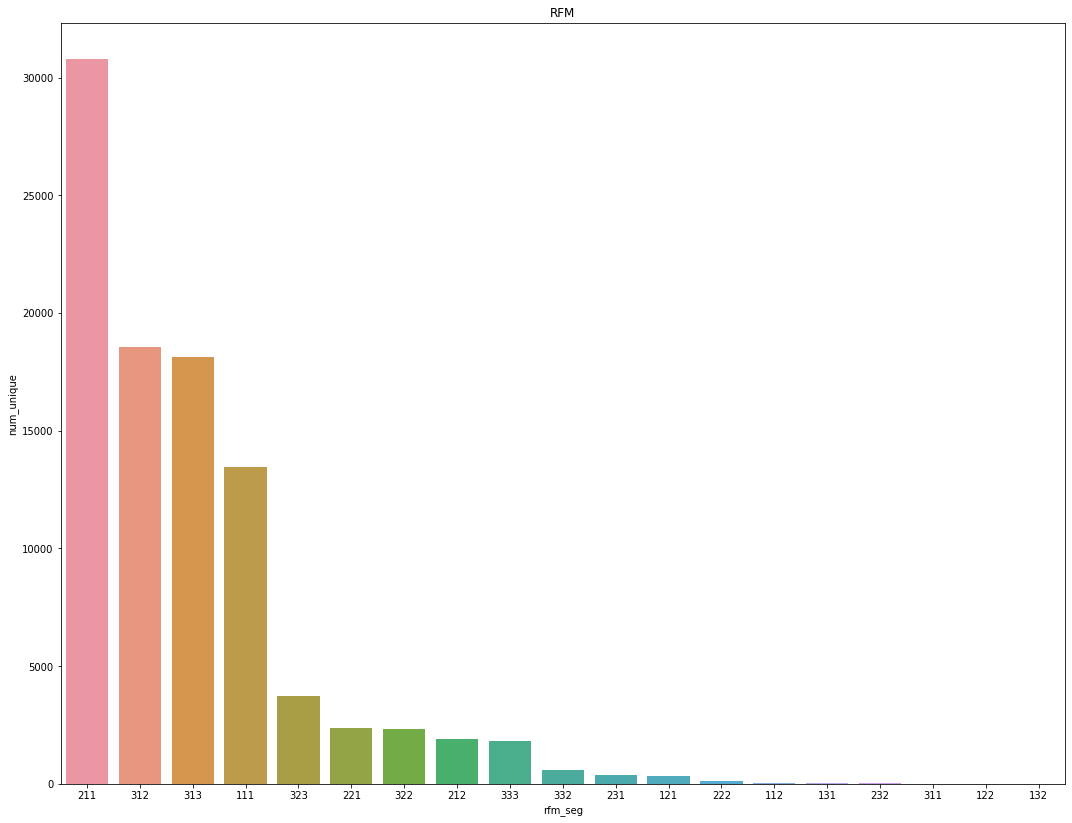

In [108]:
rfm_df_plt = rfm_df.groupby('rfm_seg', as_index=False) \
    .agg({'customer_unique_id':
          'count'}) \
    .rename(columns={'customer_unique_id':
                     'num_unique'}) \
    .sort_values('num_unique', 
                 ascending=False)
plt.figure(figsize=(18,14))
plt.title('RFM')
sns.barplot(data=rfm_df_plt, 
            x='rfm_seg', 
            y='num_unique')

Можем посчитать частоту встречаемости:

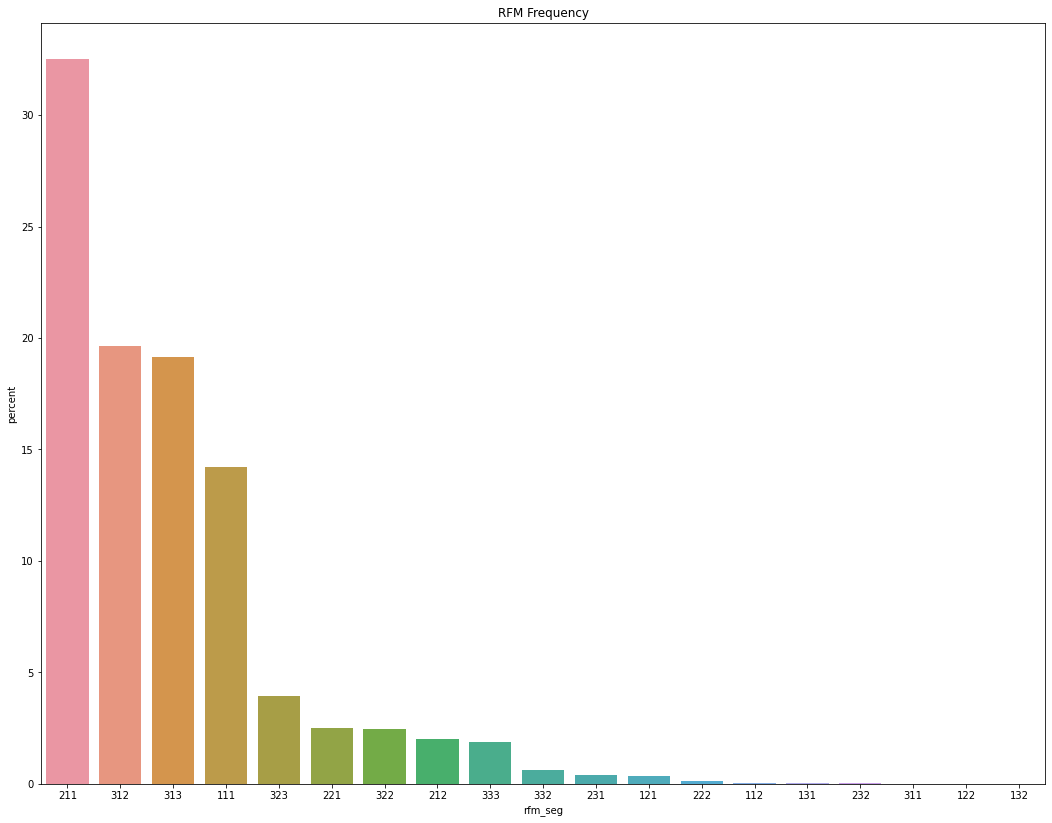

In [109]:
rfm_df_plt['percent'] = round((rfm_df_plt['num_unique'] * 100) 
                              / rfm_df_plt['num_unique'].sum(),2)
plt.figure(figsize=(18,14))
plt.title('RFM Frequency')
sns.barplot(data=rfm_df_plt, x='rfm_seg', y='percent')

Основная доля клиентов состоит в группе RFM 211 (последняя покупка в пределах 3-х месяцев, кол-во покупок = 1, суммарный объем покупки менее 89.8). Это почти 32% наших клиентов. Клиенты RFM 333 составляет около 1.9 процента.